In [1]:



# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/phakmsmote/final_data.csv
/kaggle/input/phakmsmote/pha_map.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("/kaggle/input/phakmsmote/final_data.csv")

In [4]:
y = pd.read_csv("/kaggle/input/phakmsmote/pha_map.csv")

In [5]:
X = df.drop(columns=['albedo', 'rot_per', 'e', 'a', 'q', 'om', 'w', 'ma', 'ad'])

In [6]:
X.isnull().sum()

H           0
diameter    0
i           0
n           0
per         0
moid_ld     0
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from imblearn.metrics import sensitivity_specificity_support, classification_report_imbalanced
from imblearn.over_sampling import KMeansSMOTE

In [8]:
kms = KMeansSMOTE(cluster_balance_threshold=0.01,random_state=42)
X_resampled, y_resampled = kms.fit_resample(X, y)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [9]:
X_resampled.shape

(2619186, 6)

In [10]:
y_resampled.value_counts()

pha
0      1309593
1      1309593
Name: count, dtype: int64

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled, test_size=0.2, random_state=43)

In [12]:
y_test.value_counts()

pha
0      262570
1      261268
Name: count, dtype: int64

In [13]:
!pip install dask

In [14]:
!python -m pip install dask distributed --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2024.5.2
    Uninstalling dask-2024.5.2:
      Successfully uninstalled dask-2024.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-expr 1.1.2 requires dask==2024.5.2, but you have dask 2024.7.0 which is incompatible.


In [15]:
from dask.distributed import Client
client = Client(n_workers=16)
client

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.5.2 | 2024.5.2  | 2024.7.0 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 30.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42475,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 30.00 GiB
Comm: tcp://127.0.0.1:44881,Total threads: 1
Dashboard: http://127.0.0.1:42213/status,Memory: 1.88 GiB
Nanny: tcp://127.0.0.1:45963,


In [16]:
import joblib

In [17]:
y_train = y_train.squeeze()
y_train

1205167    0
575514     0
1212305    0
1847891    1
1411332    1
          ..
1106227    0
1525776    1
1439802    1
2484501    1
1613617    1
Name: pha, Length: 2095348, dtype: int64

In [23]:
xgb = XGBClassifier()
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    xgb.fit(X_train,y_train)

In [24]:
y_pred = xgb.predict(X_test)

In [25]:
accuracy_score(y_test,y_pred)

0.999946548360371

In [26]:
confusion_matrix(y_test,y_pred)

array([[262546,     24],
       [     4, 261264]])

In [27]:
roc_auc_score(y_test,y_pred)

0.9999466429265438

In [18]:
from sklearn.model_selection import RandomizedSearchCV
xgb = XGBClassifier()
param_grid = {
    'objective' : [None, 'binary:logistic', 'binary:hinge'],
    'max_depth': [None, 20, 30, 50],
    'eta' : [0.0001, 0.001, 0.01, 0.1, 1],
    'tree_method' : ['auto', 'exact']
}

rand2 = RandomizedSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [20]:
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    rand2.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.7.0 | 2024.5.2  | 2024.7.0 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.7.0 | 2024.5.2  | 2024.7.0 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+-

In [21]:
rand2.best_params_

{'tree_method': 'exact',
 'objective': 'binary:hinge',
 'max_depth': 20,
 'eta': 0.1}

In [22]:
rand2.best_score_

0.9999680244031713

In [23]:
##Training with best parameters
xgbest = XGBClassifier(tree_method='exact',
 objective= 'binary:hinge',
 max_depth=20,
 eta=0.1)
xgbest.fit(X_train,y_train)
y_pred = xgbest.predict(X_test)

In [24]:
print(classification_report_imbalanced(y_test,y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00    262570
          1       1.00      1.00      1.00      1.00      1.00      1.00    261268

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    523838



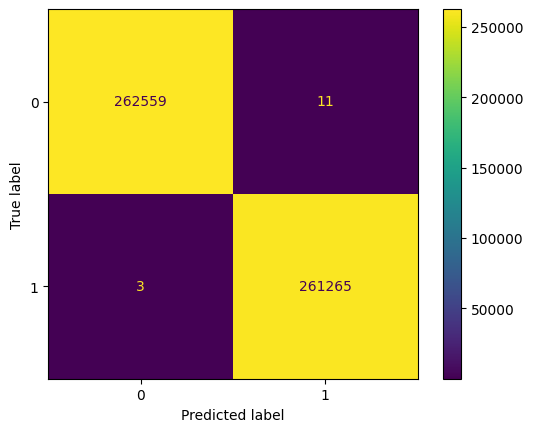

In [25]:
##Plotting Confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=xgbest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgbest.classes_)
disp.plot()
plt.show()

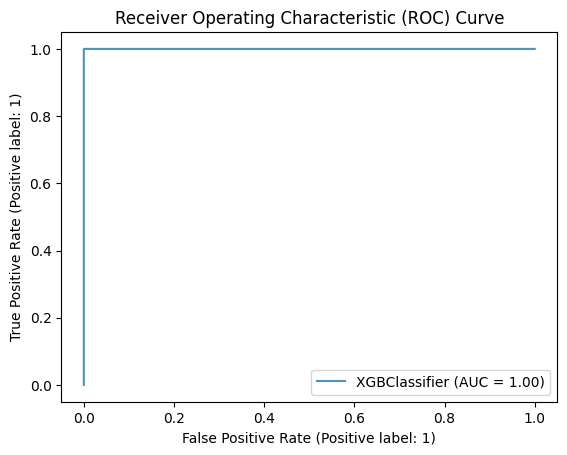

In [26]:
##Plotting ROC Curve

ax = plt.gca()
roc_display = RocCurveDisplay.from_estimator(xgbest, X_test, y_test, ax=ax, alpha=0.8)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [27]:
print(sensitivity_specificity_support(y_test, y_pred))

(array([0.99995811, 0.99998852]), array([0.99998852, 0.99995811]), array([262570, 261268]))


In [28]:
print(sensitivity_specificity_support(y_test, y_pred, average='macro'))

(0.9999733119736335, 0.9999733119736335, None)


In [29]:
print(sensitivity_specificity_support(y_test, y_pred, average='micro'))

(0.9999732741801854, 0.9999732741801854, None)


In [30]:
print(sensitivity_specificity_support(y_test, y_pred, average='weighted'))

(0.9999732741801854, 0.9999733497670815, None)


In [31]:
lgb = LGBMClassifier()
lgb.fit(X_train,y_train)
y_pred = lgb.predict(X_test)

[LightGBM] [Info] Number of positive: 1048325, number of negative: 1047023
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.514917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2095348, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


In [32]:
accuracy_score(y_test,y_pred)

0.9999522753217598

In [33]:
confusion_matrix(y_test,y_pred)

array([[262548,     22],
       [     3, 261265]])

In [34]:
roc_auc_score(y_test,y_pred)

0.9999523651784931

****Hyperparameter tuning of LightGBM is on the notebook(KMSmoteAndSmote)****

In [19]:
histgb = HistGradientBoostingClassifier()
histgb.fit(X_train,y_train)
y_pred = histgb.predict(X_test)

In [20]:
accuracy_score(y_test,y_pred)

0.9999198225405564

In [21]:
confusion_matrix(y_test,y_pred)

array([[262541,     29],
       [    13, 261255]])

In [22]:
roc_auc_score(y_test,y_pred)

0.9999198979623468

In [18]:
from sklearn.model_selection import RandomizedSearchCV
histgb = HistGradientBoostingClassifier()
param_grid = {
    'max_iter': [100, 200, 300, 500],
    'max_depth': [None, 20, 30, 50],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1]
}

rand4 = RandomizedSearchCV(histgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [19]:
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    rand4.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.7.0 | 2024.5.2  | 2024.7.0 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.7.0 | 2024.5.2  | 2024.7.0 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+-

In [20]:
rand4.best_params_

{'max_iter': 100, 'max_depth': 30, 'learning_rate': 1}

In [21]:
rand4.best_score_

0.9998930964877382

In [22]:
##Training with best parameters
histbest = HistGradientBoostingClassifier(max_iter=100, max_depth=30, learning_rate=1)
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    histbest.fit(X_train,y_train)
y_pred = histbest.predict(X_test)

In [23]:
print(classification_report_imbalanced(y_test,y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00    262570
          1       1.00      1.00      1.00      1.00      1.00      1.00    261268

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    523838



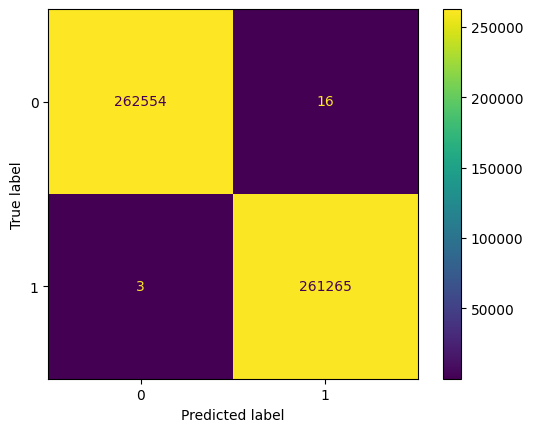

In [24]:
##Plotting Confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=histbest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=histbest.classes_)
disp.plot()
plt.show()

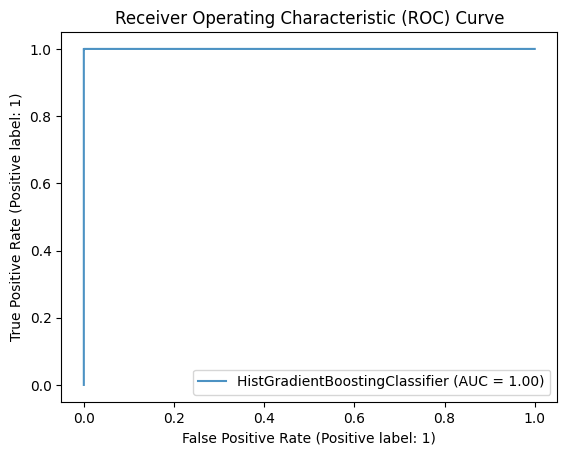

In [25]:
##Plotting ROC Curve

ax = plt.gca()
roc_display = RocCurveDisplay.from_estimator(histbest, X_test, y_test, ax=ax, alpha=0.8)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [26]:
print(sensitivity_specificity_support(y_test, y_pred))

(array([0.99993906, 0.99998852]), array([0.99998852, 0.99993906]), array([262570, 261268]))


In [27]:
print(sensitivity_specificity_support(y_test, y_pred, average='macro'))

(0.9999637907031151, 0.9999637907031151, None)


In [28]:
print(sensitivity_specificity_support(y_test, y_pred, average='micro'))

(0.9999637292445375, 0.9999637292445375, None)


In [29]:
print(sensitivity_specificity_support(y_test, y_pred, average='weighted'))

(0.9999637292445375, 0.9999638521616929, None)
